<a href="https://colab.research.google.com/github/PrinceGupta1999/Flower-Recognition-Hackerearth/blob/master/Experiment%204/Flower_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Recognition

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 128
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!unzip '/content/drive/My Drive/HE_Challenge_data.zip'

Archive:  /content/drive/My Drive/HE_Challenge_data.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
   creating: data/test/
  inflating: data/test/.DS_Store     
  inflating: data/test/18540.jpg     
  inflating: data/test/18541.jpg     
  inflating: data/test/18542.jpg     
  inflating: data/test/18543.jpg     
  inflating: data/test/18544.jpg     
  inflating: data/test/18545.jpg     
  inflating: data/test/18546.jpg     
  inflating: data/test/18547.jpg     
  inflating: data/test/18548.jpg     
  inflating: data/test/18549.jpg     
  inflating: data/test/18550.jpg     
  inflating: data/test/18551.jpg     
  inflating: data/test/18552.jpg     
  inflating: data/test/18553.jpg     
  inflating: data/test/18554.jpg     
  inflating: data/test/18555.jpg     
  inflating: data/test/18556.jpg     
  inflating: data/test/18557.jpg     
  inflating: data/test/18558.jpg     
  inflating: data/test/18559.jpg     
  inflating: data/test/18560.jpg     
  in

In [0]:
path = pathlib.Path('/content/data')
drive_path = pathlib.Path('/content/drive/My Drive/Flower_Recognition/Ex-4')

In [7]:
path.ls(), drive_path.ls()

([PosixPath('/content/data/test.csv'),
  PosixPath('/content/data/test'),
  PosixPath('/content/data/train.csv'),
  PosixPath('/content/data/train'),
  PosixPath('/content/data/sample_submission.csv')],
 [PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/data0.pkl'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/stage-1-rn152.pth'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/data1.pkl'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/data2.pkl'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/data3.pkl'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/stage-2-rn152.pth'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/rn_152.pt'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/w1.pt'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/stage-1-rn50.pth'),
  PosixPath('/content/drive/My Drive/Flower_Recognition/Ex-4/stage-2-rn50.pth'),
  PosixPath('/content/drive/My 

In [0]:
df_train = pd.read_csv(path/'train.csv')

In [0]:
df_train[:10]

image_id  category
0         0        77
1         1        81
2         2        52
3         3        72
4         4        58
5         5         2
6         6        75
7         7        67
8         8        51
9         9        15

In [0]:
df_train['category'].value_counts()

51     582
77     567
46     441
73     438
89     414
74     387
81     375
94     366
88     348
78     309
83     297
43     294
41     288
95     288
75     270
58     258
82     252
60     246
56     246
76     243
37     243
80     237
65     231
72     216
53     210
44     210
23     207
96     207
50     207
12     198
      ... 
64     117
61     114
19     111
15     111
49     111
100    111
13     111
14     108
102    108
93     105
9      105
33     105
32     102
6      102
10     102
35      99
67      96
24      96
39      93
79      93
25      93
26      93
16      93
34      90
3       90
21      90
7       90
1       90
27      90
45      90
Name: category, Length: 102, dtype: int64

#### Different Datasets for different models by changing seed

In [0]:
tfms = get_transforms(max_rotate=25.0, max_zoom=1.3, max_lighting=0.3, xtra_tfms=[cutout(length=(15, 25))])

In [0]:
data =  (ImageList.from_df(df_train, path=path, folder='train', suffix='.jpg')
        #Where to find the data? -> in dataframe
        .split_by_rand_pct(valid_pct=0.4, seed=3)
        #How to split in train/valid? -> randomly 40% in valid
        .label_from_df()
        #How to label? -> use the second column of the dataframe file      
        .transform(tfms, size=299)
        #Data augmentation? -> use tfms with a size of 128
        .add_test_folder(test_folder='test')
        .databunch(bs=bs)
        #Finally -> use the defaults for conversion to databunch
         .normalize(imagenet_stats)) 

In [0]:
data.save(drive_path/'data3.pkl')

#### Getting saved data

In [0]:
data = load_data(path=drive_path, file='data3.pkl', bs=bs//4)

In [43]:
data.train_ds

LabelList (11124 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
81,52,72,58,2
Path: /content/data

In [44]:
data.valid_ds

LabelList (7416 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
81,3,30,74,77
Path: /content/data

In [45]:
data.test_ds

LabelList (2009 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: /content/data

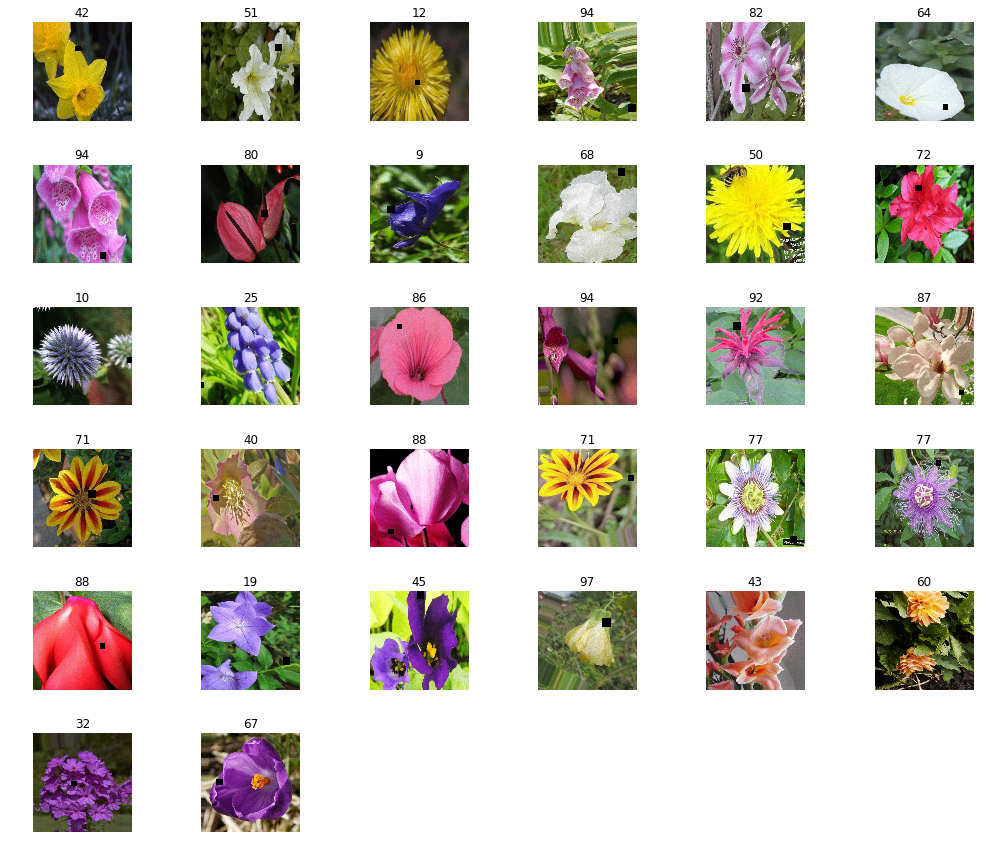

In [0]:
data.show_batch(rows=9, figsize=(14,12))

In [0]:
len(data.classes)

102

#### Creating weigted loss function

In [0]:
counts = Counter(data.train_ds.y.items)

In [0]:
counts = [(len(data.train_ds) / counts[k]) for k in range(102)]

In [48]:
counts[:5]

[191.79310344827587,
 137.33333333333334,
 206.0,
 132.42857142857142,
 135.65853658536585]

In [0]:
class_weights = tensor(np.interp(counts, (min(counts), max(counts)), (0.1, 1.)))

In [50]:
class_weights[:10]

tensor([0.8553, 0.5985, 0.9223, 0.5754, 0.5906, 0.7970, 0.9046, 0.4458, 0.7970,
        0.7003], dtype=torch.float64)

In [0]:
w0 = class_weights[:]

In [0]:
torch.save(w0, drive_path/'w0.pt')

In [0]:
w1 = class_weights[:]

In [0]:
torch.save(w1, drive_path/'w1.pt')

In [0]:
w2 = class_weights[:]

In [0]:
torch.save(w2, drive_path/'w2.pt')

In [0]:
w3 = class_weights[:]

In [0]:
torch.save(w3, drive_path/'w3.pt')

In [53]:
print(float(w0[0]), float(w1[0]), float(w2[0]), float(w3[0]))
len(w0) == len(w1) == len(w2) == len(w3)

0.839026748308089 0.8484441732763881 1.0 0.8553094313770269


True

In [0]:
# loss_func = nn.NLLLoss(weight=class_weights)

# Training with Resnet

## Training: resnet152

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
data = load_data(path=drive_path, file='data0.pkl', bs=bs//4)
w0 = torch.load(drive_path/'w0.pt')
loss_func = nn.NLLLoss(weight=w0) 

In [0]:
learn = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy], model_dir=drive_path)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 88413942.35it/s]


In [0]:
learn.crit = loss_func

### Training Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


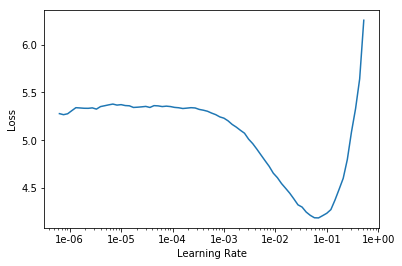

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [0]:
learn.fit_one_cycle(4, max_lr=slice(lr))

In [0]:
learn.save('stage-1-rn152')

### Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

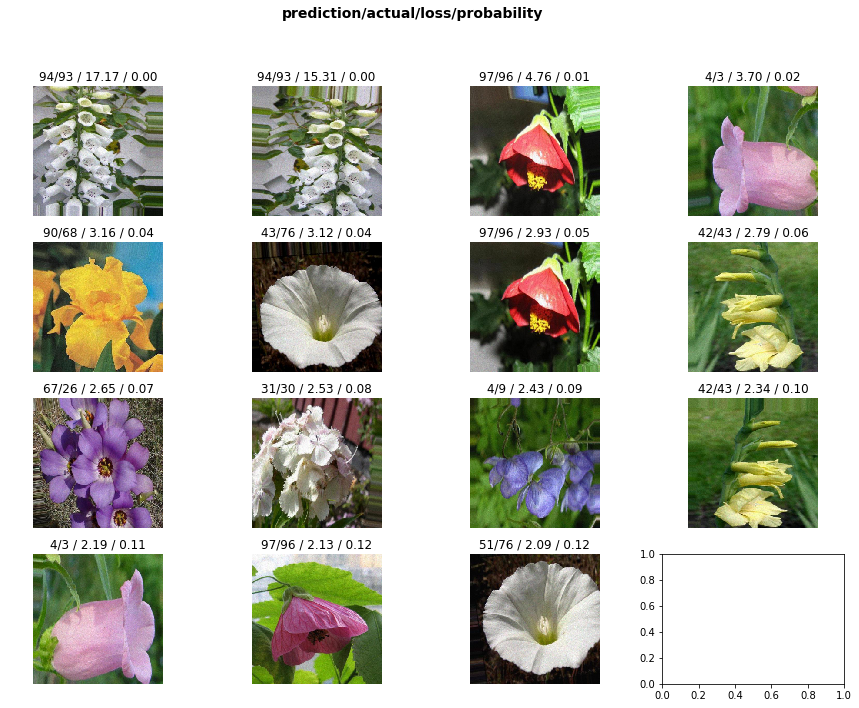

In [0]:
interp.plot_top_losses(16, figsize=(15,11))

In [0]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[(96, 97, 6),
 (30, 31, 3),
 (43, 42, 3),
 (3, 4, 2),
 (9, 4, 2),
 (68, 90, 2),
 (76, 51, 2),
 (92, 33, 2),
 (93, 94, 2),
 (98, 4, 2)]

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.load('stage-1-rn152');

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


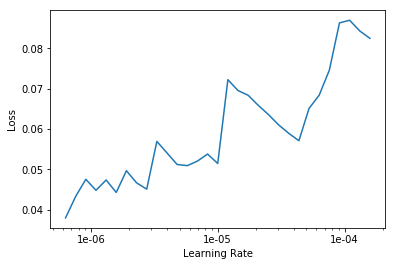

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-7, lr/20))

That's a pretty accurate model!

In [0]:
learn.save('stage-2-rn152')

### Making Predictions

In [0]:
learn.load('stage-2-rn152')

Learner(data=ImageDataBunch;

Train: LabelList (11124 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
77,81,52,72,58
Path: /content/data;

Valid: LabelList (7416 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
51,69,84,46,37
Path: /content/data;

Test: LabelList (2009 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: /content/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 

In [0]:
preds_rn152, _ = learn.TTA(ds_type=DatasetType.Test, beta=0.25)

In [0]:
torch.save(preds_rn152, drive_path/'rn_152.pt')

In [0]:
preds_rn152.shape

torch.Size([2009, 102])

In [0]:
data.test_ds.items[:10]

array([PosixPath('/content/data/test/19952.jpg'), PosixPath('/content/data/test/20037.jpg'),
       PosixPath('/content/data/test/20175.jpg'), PosixPath('/content/data/test/18758.jpg'),
       PosixPath('/content/data/test/19228.jpg'), PosixPath('/content/data/test/18626.jpg'),
       PosixPath('/content/data/test/19831.jpg'), PosixPath('/content/data/test/20435.jpg'),
       PosixPath('/content/data/test/18703.jpg'), PosixPath('/content/data/test/18872.jpg')], dtype=object)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = load_data(path=drive_path, file='data1.pkl', bs=bs//2)
w1 = torch.load(drive_path/'w1.pt')
loss_func = nn.NLLLoss(weight=w1) 

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy], model_dir=drive_path)

In [0]:
learn.crit = loss_func

### Learning Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


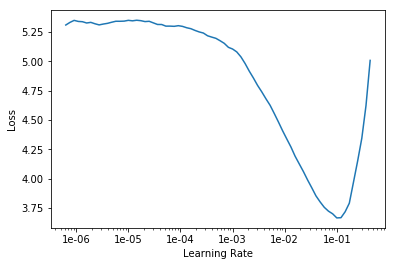

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2

In [0]:
learn.fit_one_cycle(4, max_lr=slice(lr))

In [0]:
learn.save('stage-1-rn50')

### Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

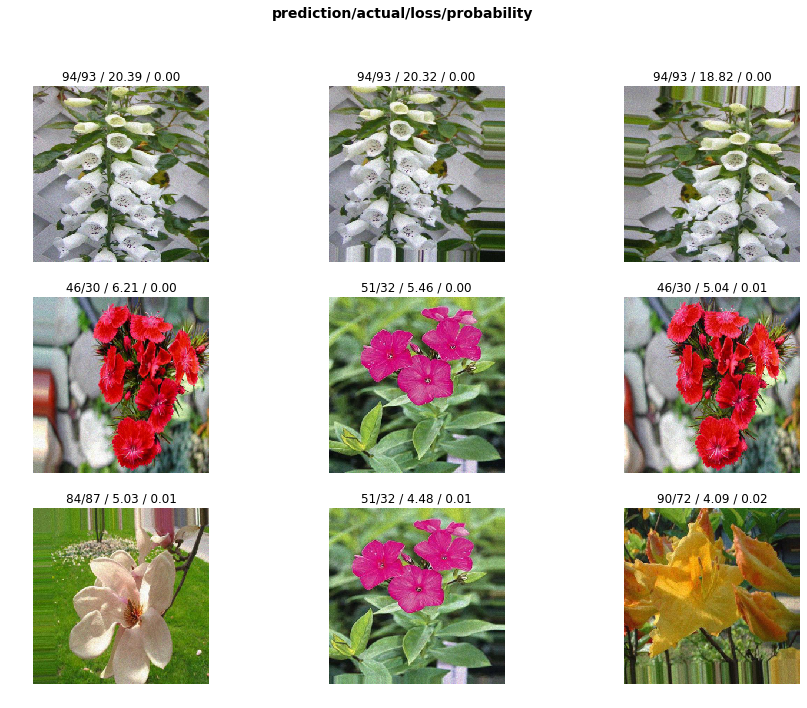

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[(96, 97, 7),
 (3, 4, 3),
 (30, 46, 3),
 (87, 84, 3),
 (93, 94, 3),
 (97, 40, 3),
 (4, 11, 2),
 (6, 23, 2),
 (11, 46, 2),
 (12, 15, 2),
 (15, 68, 2),
 (16, 47, 2),
 (30, 89, 2),
 (32, 51, 2),
 (32, 76, 2),
 (40, 91, 2),
 (45, 3, 2),
 (48, 26, 2),
 (72, 90, 2),
 (76, 51, 2),
 (96, 56, 2),
 (99, 71, 2)]

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.load('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


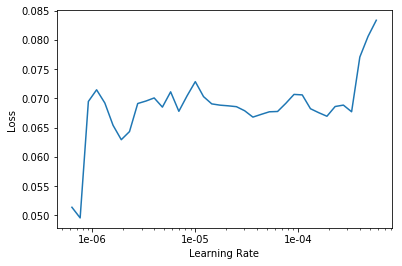

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, max_lr=slice(3e-6,lr/20))

That's a pretty accurate model!

In [0]:
learn.save('stage-2-rn50')

### Making Predictions

In [0]:
learn.load('stage-2-rn50')

In [0]:
preds_rn50, _ = learn.TTA(ds_type=DatasetType.Test, beta=0.25)

In [0]:
torch.save(preds_rn50, drive_path/'rn_50.pt')

In [0]:
preds_rn50.shape

torch.Size([2009, 102])

In [0]:
data.test_ds.items[:10]

array([PosixPath('/content/data/test/19952.jpg'), PosixPath('/content/data/test/20037.jpg'),
       PosixPath('/content/data/test/20175.jpg'), PosixPath('/content/data/test/18758.jpg'),
       PosixPath('/content/data/test/19228.jpg'), PosixPath('/content/data/test/18626.jpg'),
       PosixPath('/content/data/test/19831.jpg'), PosixPath('/content/data/test/20435.jpg'),
       PosixPath('/content/data/test/18703.jpg'), PosixPath('/content/data/test/18872.jpg')], dtype=object)

# Training with DenseNet

## Training: densenet161

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
data = load_data(path=drive_path, file='data2.pkl', bs=bs//8)
w2 = torch.load(drive_path/'w2.pt')
loss_func = nn.NLLLoss(weight=w2) 

In [0]:
learn = cnn_learner(data, models.densenet161, metrics=[error_rate, accuracy], model_dir=drive_path)

In [0]:
learn.crit = loss_func

### Training Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


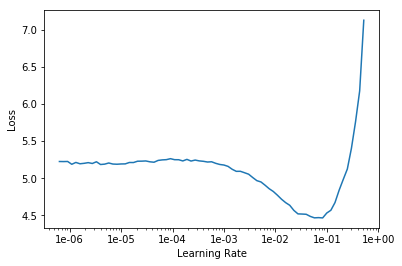

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [0]:
learn.fit_one_cycle(4, max_lr=slice(lr))

In [0]:
learn.save('stage-1-dn161')

### Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

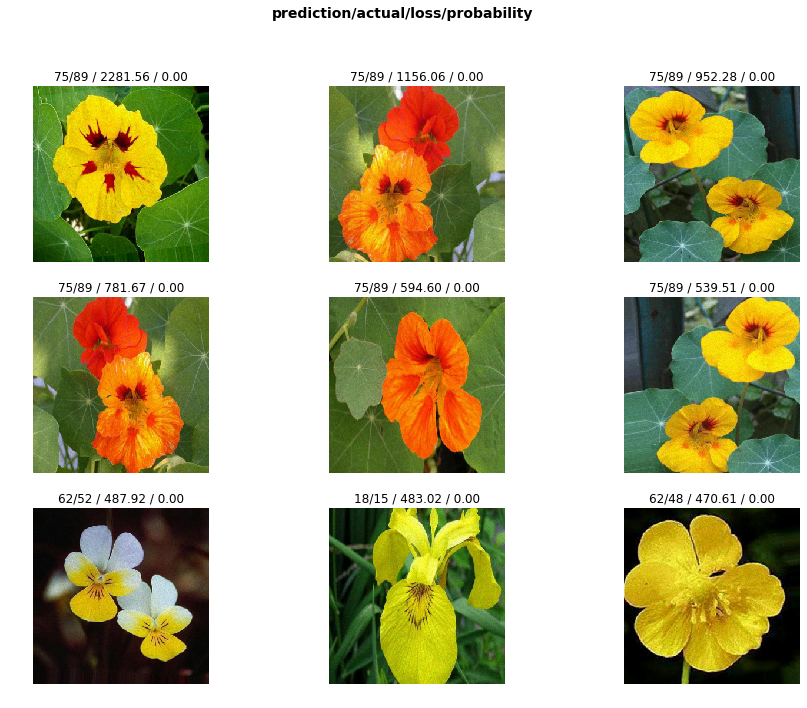

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[(89, 75, 11),
 (19, 39, 10),
 (96, 97, 8),
 (91, 69, 6),
 (15, 18, 4),
 (73, 69, 4),
 (7, 62, 3),
 (11, 74, 3),
 (50, 69, 3),
 (69, 73, 3),
 (95, 4, 3),
 (99, 101, 3),
 (2, 62, 2),
 (3, 58, 2),
 (4, 74, 2),
 (5, 41, 2),
 (22, 7, 2),
 (25, 78, 2),
 (26, 80, 2),
 (40, 96, 2),
 (48, 62, 2),
 (48, 80, 2),
 (56, 62, 2),
 (57, 84, 2),
 (68, 90, 2),
 (83, 86, 2),
 (90, 74, 2),
 (94, 93, 2),
 (97, 96, 2)]

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.load('stage-1-dn161')

Learner(data=ImageDataBunch;

Train: LabelList (11124 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
72,75,67,15,77
Path: /content/data;

Valid: LabelList (7416 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
72,50,78,91,39
Path: /content/data;

Test: LabelList (2009 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: /content/data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _Dense

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


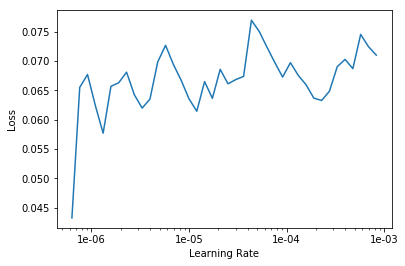

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, max_lr=slice(1e-6, lr/20))

That's a pretty accurate model!

In [0]:
learn.save('stage-2-dn161')

### Making Predictions

In [0]:
learn.load('stage-2-dn161')

In [0]:
preds_dn161, _ = learn.TTA(ds_type=DatasetType.Test, beta=0.25)

In [0]:
torch.save(preds_dn161, drive_path/'dn_161.pt')

In [0]:
preds_dn161.shape

torch.Size([2009, 102])

In [0]:
data.test_ds.items[:10]

array([PosixPath('/content/data/test/19952.jpg'), PosixPath('/content/data/test/20037.jpg'),
       PosixPath('/content/data/test/20175.jpg'), PosixPath('/content/data/test/18758.jpg'),
       PosixPath('/content/data/test/19228.jpg'), PosixPath('/content/data/test/18626.jpg'),
       PosixPath('/content/data/test/19831.jpg'), PosixPath('/content/data/test/20435.jpg'),
       PosixPath('/content/data/test/18703.jpg'), PosixPath('/content/data/test/18872.jpg')], dtype=object)

## Training: densenet201

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = load_data(path=drive_path, file='data3.pkl', bs=bs//8)
w3 = torch.load(drive_path/'w3.pt')
loss_func = nn.NLLLoss(weight=w3) 

In [55]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy], model_dir=drive_path)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:02<00:00, 27881159.40it/s]


In [0]:
learn.crit = loss_func

### Training Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


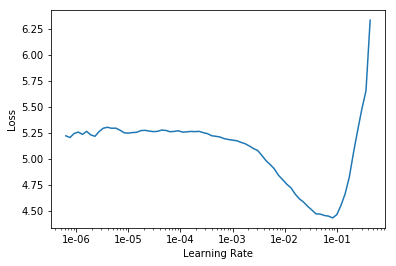

In [57]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2

In [59]:
learn.fit_one_cycle(4, max_lr=slice(lr))

In [0]:
learn.save('stage-1-dn201')

### Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [61]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

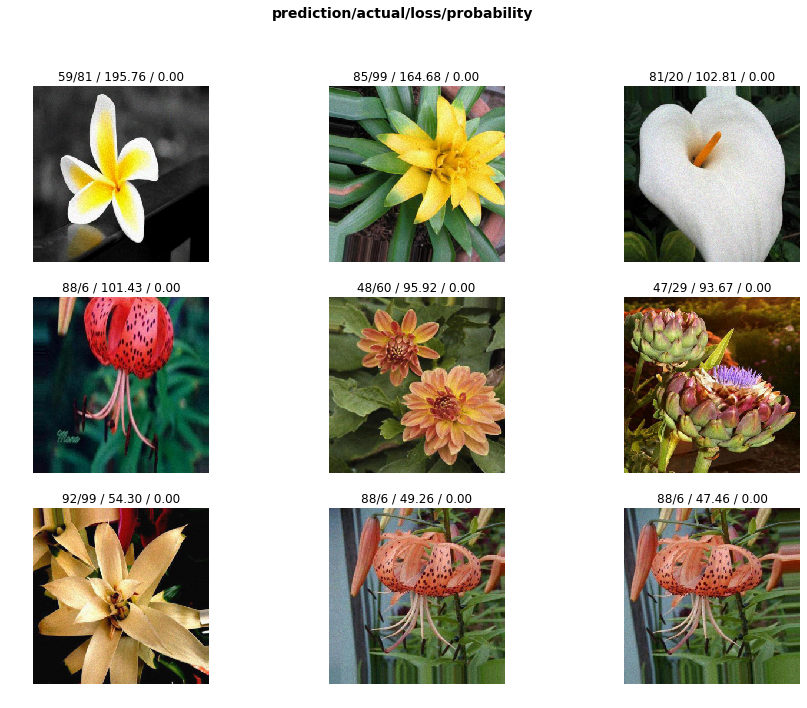

In [62]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [64]:
interp.most_confused(min_val=2)

[(96, 97, 9),
 (6, 88, 3),
 (26, 45, 3),
 (62, 34, 3),
 (62, 96, 3),
 (81, 59, 3),
 (98, 19, 3),
 (4, 9, 2),
 (40, 23, 2),
 (84, 18, 2),
 (95, 96, 2),
 (97, 83, 2),
 (99, 85, 2),
 (99, 92, 2)]

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.load('stage-1-dn201')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


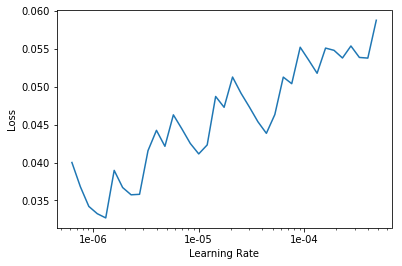

In [68]:
learn.lr_find()
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(6, max_lr=slice(3e-7,lr/20))

That's a pretty accurate model!

In [0]:
learn.save('stage-2-dn201')

### Making Predictions

In [0]:
learn.load('stage-2-dn201')

In [71]:
preds_dn201, _ = learn.TTA(ds_type=DatasetType.Test, beta=0.25)

In [0]:
torch.save(preds_dn201, drive_path/'dn_201.pt')

In [73]:
preds_dn201.shape

torch.Size([2009, 102])

In [74]:
data.test_ds.items[:10]

array([PosixPath('/content/data/test/19952.jpg'), PosixPath('/content/data/test/20037.jpg'),
       PosixPath('/content/data/test/20175.jpg'), PosixPath('/content/data/test/18758.jpg'),
       PosixPath('/content/data/test/19228.jpg'), PosixPath('/content/data/test/18626.jpg'),
       PosixPath('/content/data/test/19831.jpg'), PosixPath('/content/data/test/20435.jpg'),
       PosixPath('/content/data/test/18703.jpg'), PosixPath('/content/data/test/18872.jpg')], dtype=object)

# Finalizing Test Results

In [0]:
preds_rn152 = torch.load(drive_path/'rn_152.pt')
preds_rn50 = torch.load(drive_path/'rn_50.pt')
preds_dn161 = torch.load(drive_path/'dn_161.pt')
preds_dn201 = torch.load(drive_path/'dn_201.pt')

In [0]:
preds = preds_rn50 + preds_rn152 + preds_dn161 + preds_dn201

In [77]:
[int(np.argmax(pred)) + 1 for pred in preds_rn50[:5]]

[48, 77, 58, 82, 55]

In [78]:
[int(np.argmax(pred)) + 1 for pred in preds_rn152[:5]]

[48, 77, 58, 82, 55]

In [79]:
[int(np.argmax(pred)) + 1 for pred in preds_dn161[:5]]

[48, 77, 58, 82, 55]

In [80]:
[int(np.argmax(pred)) + 1 for pred in preds_dn201[:5]]

[48, 77, 58, 82, 55]

In [0]:
labels = [int(np.argmax(pred) + 1) for pred in preds]

In [82]:
labels[:5]

[48, 77, 58, 82, 55]

In [0]:
images = [p.stem for p in data.test_ds.items]

In [84]:
images[:5]

['19952', '20037', '20175', '18758', '19228']

In [0]:
submission = pd.DataFrame({
    'image_id': images,
    'category': labels
})
submission = submission.sort_values(by = ['image_id'], ascending = [True])
submission.to_csv(drive_path/'submission.csv',index=False)